In [1]:
# Get bitcoin data from GeckoAPI
from pycoingecko import CoinGeckoAPI
from datetime import datetime 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

import requests
from pathlib import Path

## Use API to gather data.

In [2]:
cg = CoinGeckoAPI()

# Get previous prices (1 yr + 1 day)
data = cg.get_coin_market_chart_by_id(id='bitcoin', vs_currency='usd', days='366', interval='daily')

# keys of data dictionary.
data.keys()

dict_keys(['prices', 'market_caps', 'total_volumes'])

## Bitcoin dataframe

In [3]:
# Create Bitcoin data frame based on the dictionary from cg api.
bitcoin_df = pd.DataFrame()

bitcoin_df['Date'] = pd.DataFrame(data['prices'])[0]
bitcoin_df['Price'] = pd.DataFrame(data['prices'])[1]
bitcoin_df['Total_Vols'] = pd.DataFrame(data['total_volumes'])[1]
bitcoin_df['Market Cap'] = pd.DataFrame(data['market_caps'])[1]

bitcoin_df

,Date,Price,Total_Vols,Market Cap
0,1592870400000,9678.683209,2.476862e+10,1.781287e+11
1,1592956800000,9624.684292,1.775680e+10,1.771870e+11
2,1593043200000,9288.061774,2.318376e+10,1.710283e+11
3,1593129600000,9258.667161,2.349918e+10,1.704953e+11
4,1593216000000,9166.486360,2.242920e+10,1.688071e+11
...,...,...,...,...
362,1624147200000,35581.642268,2.885898e+10,6.669013e+11
363,1624233600000,35787.077405,3.560913e+10,6.706344e+11
364,1624320000000,31711.935468,5.187387e+10,5.983357e+11
365,1624406400000,32507.738707,5.744301e+10,6.065800e+11


In [4]:
# Clean data format
# Unix timestamp -> utc format
bitcoin_df['Date'] = bitcoin_df['Date'].apply(lambda x: datetime.utcfromtimestamp(int(x) / 1000).strftime('%Y-%m-%d'))

# Show only 2 decimals (will not modify actual value)
pd.options.display.float_format = "{:,.2f}".format
bitcoin_df

,Date,Price,Total_Vols,Market Cap
0,2020-06-23,"9,678.68","24,768,621,256.84","178,128,652,479.62"
1,2020-06-24,"9,624.68","17,756,804,210.06","177,187,041,226.60"
2,2020-06-25,"9,288.06","23,183,760,291.75","171,028,279,701.50"
3,2020-06-26,"9,258.67","23,499,175,984.22","170,495,281,892.46"
4,2020-06-27,"9,166.49","22,429,204,010.64","168,807,143,703.19"
...,...,...,...,...
362,2021-06-20,"35,581.64","28,858,979,691.79","666,901,325,910.37"
363,2021-06-21,"35,787.08","35,609,127,163.62","670,634,370,556.61"
364,2021-06-22,"31,711.94","51,873,870,276.52","598,335,733,135.87"
365,2021-06-23,"32,507.74","57,443,014,757.92","606,580,031,922.72"


In [5]:
# Create new column indicating price change from previous day
bitcoin_df['Difference ($)'] = bitcoin_df['Price'] - bitcoin_df['Price'].shift(periods = 1)

# Create new column indicating price change in percentage from previous day
bitcoin_df['Difference (%)'] = (1 - bitcoin_df['Price'].shift(periods = 1) / bitcoin_df['Price']) * 100 

# Create new column indicating price change in percentage from previous day
bitcoin_df['Volume Change (%)'] = (1 - bitcoin_df['Total_Vols'].shift(periods = 1) / bitcoin_df['Total_Vols']) * 100 

bitcoin_df.dropna(inplace=True)

# Boolean value of whether price whent up.
# 0 change is considered 'up', since there will be no loss of profit.
bitcoin_df['Up'] = bitcoin_df['Difference ($)'].apply(lambda x: True if x >= 0 else False).shift(periods = -1)

bitcoin_df.dropna(inplace=True)

bitcoin_df.head(10)

,Date,Price,Total_Vols,Market Cap,Difference ($),Difference (%),Volume Change (%),Up
1,2020-06-24,"9,624.68","17,756,804,210.06","177,187,041,226.60",-54.00,-0.56,-39.49,False
2,2020-06-25,"9,288.06","23,183,760,291.75","171,028,279,701.50",-336.62,-3.62,23.41,False
3,2020-06-26,"9,258.67","23,499,175,984.22","170,495,281,892.46",-29.39,-0.32,1.34,False
4,2020-06-27,"9,166.49","22,429,204,010.64","168,807,143,703.19",-92.18,-1.01,-4.77,False
5,2020-06-28,"9,013.91","21,515,626,881.10","166,004,979,429.80",-152.58,-1.69,-4.25,True
6,2020-06-29,"9,139.90","19,665,935,216.70","168,334,049,772.47",126.00,1.38,-9.41,True
7,2020-06-30,"9,185.17","19,754,459,582.75","169,175,896,894.16",45.26,0.49,0.45,False
8,2020-07-01,"9,149.72","19,741,435,780.49","168,558,715,595.08",-35.44,-0.39,-0.07,True
9,2020-07-02,"9,230.67","20,005,031,554.02","170,031,996,602.77",80.95,0.88,1.32,False
10,2020-07-03,"9,094.32","19,379,463,385.30","167,604,994,105.35",-136.35,-1.50,-3.23,False


## Bitcoin consecutive movement Data Frame

In [6]:
# Trend of consecutive movement
# Total amount of change in both amount and percentage during each consecutive movement

ls = []
count = 0
prev = None
amount = None
b_price = None

for index, row in bitcoin_df.iterrows():
    i = row['Up']
    t = row["Difference ($)"]
    p = row["Price"]
    
    if i == prev:
        count+=1
        amount += t
        
    else:
        ls.append([("Up" if prev else "Down"), count, amount, (None if amount==None else amount/b_price*100)])
        prev = i
        count = 1
        amount = t
        b_price = p
        
bitcoint_trend_df = pd.DataFrame(ls).rename(columns={0: "Up/Down", 1: "# of days", 2: "Amount ($)", 3: "Amount (%)"})

bitcoint_trend_df.dropna(inplace=True)

bitcoint_trend_df

,Up/Down,# of days,Amount ($),Amount (%)
1,Down,4,-512.20,-5.32
2,Up,2,-26.58,-0.29
3,Down,1,45.26,0.49
4,Up,1,-35.44,-0.39
5,Down,2,-55.40,-0.60
...,...,...,...,...
203,Down,1,386.13,1.04
204,Up,2,"1,858.27",5.21
205,Down,5,"-3,266.59",-8.04
206,Up,1,-299.47,-0.84


In [7]:
# Looping to gether data from api and get daily maximum and minimum


# Find correlation among Total Vol, Price change, consecutive movement.
# Need more data 5 yrs
# 

## Bitcoin Price Data Frame

In [8]:
bitcoin_price_df =  bitcoin_df[["Date","Price"]]
bitcoin_price_df

,Date,Price
1,2020-06-24,"9,624.68"
2,2020-06-25,"9,288.06"
3,2020-06-26,"9,258.67"
4,2020-06-27,"9,166.49"
5,2020-06-28,"9,013.91"
...,...,...
361,2021-06-19,"35,881.11"
362,2021-06-20,"35,581.64"
363,2021-06-21,"35,787.08"
364,2021-06-22,"31,711.94"


In [9]:
pre_three_days_average = []
pre_seven_days_average = []
pre_thirty_days_average = []
post_three_days_average = []
post_seven_days_average = []

for i in range(len(bitcoin_df)):
    pre_three_average = np.mean(bitcoin_df[i-3:i+1]['Price'])
    pre_three_days_average.append(pre_three_average)
    
    pre_seven_average = np.mean(bitcoin_df[i-7:i+1]['Price'])
    pre_seven_days_average.append(pre_seven_average)
    
    pre_thirty_average = np.mean(bitcoin_df[i-30:i+1]['Price'])
    pre_thirty_days_average.append(pre_thirty_average)
    
    post_three_average = np.mean(bitcoin_df[i:i+4]['Price'])
    post_three_days_average.append(post_three_average)
    
    post_seven_average = np.mean(bitcoin_df[i:i+8]['Price'])
    post_seven_days_average.append(post_seven_average)
    
    
bitcoin_price_df["Pre 3 days Mean"] = pd.DataFrame(pre_three_days_average)
bitcoin_price_df["Pre 7 days Mean"] = pd.DataFrame(pre_seven_days_average)
bitcoin_price_df["Pre 30 days Mean"] = pd.DataFrame(pre_thirty_days_average)
bitcoin_price_df["Post 3 days Mean"] = pd.DataFrame(post_three_days_average)
bitcoin_price_df["Post 7 days Mean"] = pd.DataFrame(post_seven_days_average)

#bitcoin_price_df.dropna(inplace=True)
bitcoin_price_df

,Date,Price,Pre 3 days Mean,Pre 7 days Mean,Pre 30 days Mean,Post 3 days Mean,Post 7 days Mean
1,2020-06-24,"9,624.68",NaN,NaN,NaN,"9,181.78","9,179.07"
2,2020-06-25,"9,288.06",NaN,NaN,NaN,"9,144.74","9,154.86"
3,2020-06-26,"9,258.67","9,334.47",NaN,NaN,"9,126.37","9,131.44"
4,2020-06-27,"9,166.49","9,181.78",NaN,NaN,"9,122.17","9,127.25"
5,2020-06-28,"9,013.91","9,144.74",NaN,NaN,"9,176.37","9,136.44"
...,...,...,...,...,...,...,...
361,2021-06-19,"35,881.11","36,994.46","37,974.30","37,196.96","33,897.10","33,897.10"
362,2021-06-20,"35,581.64","36,360.86","37,989.42","37,046.93","33,335.58","33,335.58"
363,2021-06-21,"35,787.08","34,740.44","37,059.94","36,865.40","32,109.84","32,109.84"
364,2021-06-22,"31,711.94","33,897.10","36,045.35","36,703.70","32,507.74","32,507.74"


# Simple Visualization

In [10]:
bitcoin_df

,Date,Price,Total_Vols,Market Cap,Difference ($),Difference (%),Volume Change (%),Up
1,2020-06-24,"9,624.68","17,756,804,210.06","177,187,041,226.60",-54.00,-0.56,-39.49,False
2,2020-06-25,"9,288.06","23,183,760,291.75","171,028,279,701.50",-336.62,-3.62,23.41,False
3,2020-06-26,"9,258.67","23,499,175,984.22","170,495,281,892.46",-29.39,-0.32,1.34,False
4,2020-06-27,"9,166.49","22,429,204,010.64","168,807,143,703.19",-92.18,-1.01,-4.77,False
5,2020-06-28,"9,013.91","21,515,626,881.10","166,004,979,429.80",-152.58,-1.69,-4.25,True
...,...,...,...,...,...,...,...,...
361,2021-06-19,"35,881.11","35,162,612,172.75","673,761,687,974.49","-2,312.51",-6.44,-3.32,False
362,2021-06-20,"35,581.64","28,858,979,691.79","666,901,325,910.37",-299.47,-0.84,-21.84,True
363,2021-06-21,"35,787.08","35,609,127,163.62","670,634,370,556.61",205.44,0.57,18.96,False
364,2021-06-22,"31,711.94","51,873,870,276.52","598,335,733,135.87","-4,075.14",-12.85,31.35,True


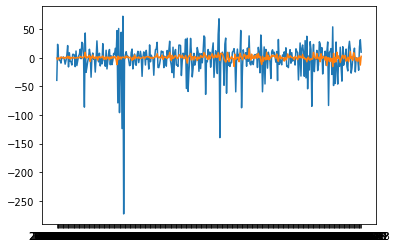

In [11]:
plt.plot(bitcoin_df['Date'], bitcoin_df['Volume Change (%)'])
plt.plot(bitcoin_df['Date'], bitcoin_df['Difference (%)'])
plt.margins(0.05) 
plt.show()

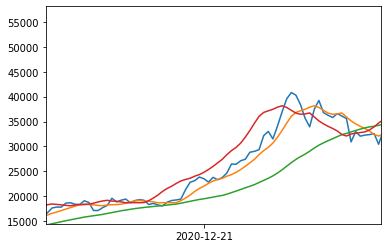

In [12]:
plt.plot(bitcoin_df['Date'], bitcoin_price_df['Price'])
#plt.plot(bitcoin_df['Date'], bitcoin_price_df['Pre 3 days Mean'])
plt.plot(bitcoin_df['Date'], bitcoin_price_df['Pre 7 days Mean']) # Orange
plt.plot(bitcoin_df['Date'], bitcoin_price_df['Pre 30 days Mean']) # Green
#plt.plot(bitcoin_df['Date'], bitcoin_price_df['Post 3 days Mean'])
plt.plot(bitcoin_df['Date'], bitcoin_price_df['Post 7 days Mean']) # Red
plt.xticks(np.arange(0, len(bitcoin_price_df['Date']) - 1, 90))
plt.margins(x=-0.4, y=-.1)
plt.show()

# Prediction and Accuracy

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model = LinearRegression()

Prediction based on Price :  -0.02871221340939978


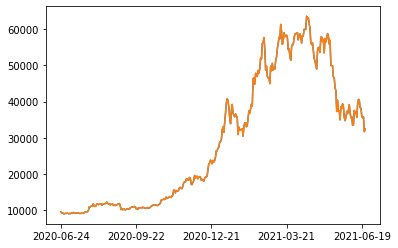

Prediction based on Total_Vols :  -0.010973944168498617


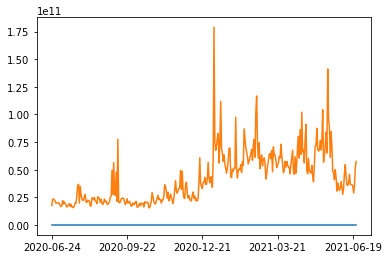

Prediction based on Market Cap :  -0.02899705173911915


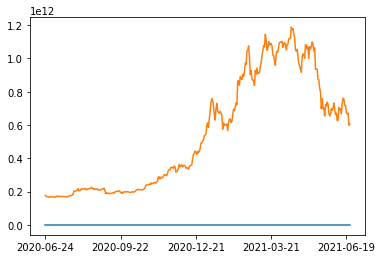

Prediction based on Difference ($) :  0.00238816560143873


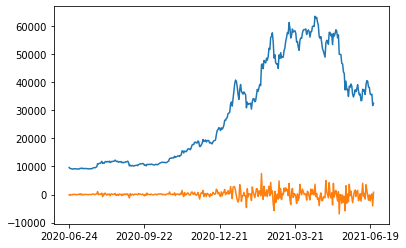

Prediction based on Difference (%) :  0.006002812943109892


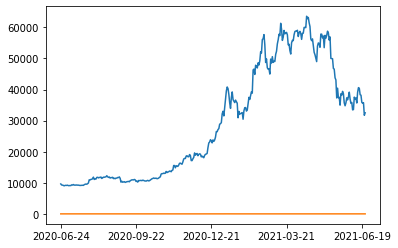

Prediction based on Volume Change (%) :  -0.004150954876216195


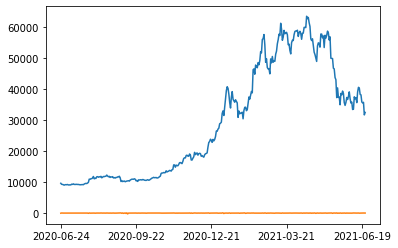

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

for i in bitcoin_df.columns:
    if (i == "Date") | (i == "Up"):
        continue
    X = bitcoin_df[[i]]
    Y = bitcoin_df['Up']
    
    tr_x, ts_x = train_test_split(X, test_size=0.1, random_state=43)
    tr_y, ts_y = train_test_split(Y, test_size=0.1, random_state=43)
    
    model = LinearRegression()
    model = model.fit(tr_x, tr_y)
    #model = model.fit(ts_x, ts_y)
    r_sq = model.score(ts_x, ts_y)

    print("Prediction based on " + i + " : ", r_sq)
    
    plt.plot(bitcoin_df['Date'], bitcoin_df['Price'])
    plt.plot(bitcoin_df['Date'], bitcoin_df[i])
    plt.xticks(np.arange(0, len(bitcoin_df['Date']) - 1, 90))
    plt.show()